In [1]:
#from libs.prefect_helpers import *
from libs.data_manipulation import *
from libs.feature_generation import *
#from libs.dim_reduction import *
from libs.football_plots import *
#from libs.clustering import *
from libs.convex_hull import *

import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree

from mplsoccer import *
import pandas as pd
import numpy as np
import os
# Click player into the pitch and take those player and apply Ripleys K to them. And then maybe PCA


In [4]:
# Step 6: Extract match data from tracking data
data = compile_team_tracking_data("data/H_EURO2024GERMANY", "Denmark")
print(data.head())
one_match = extract_one_match(data, 1)
#mean_xy = calculate_xy_mean(one_match.iloc[::48].filter(regex="^home").to_numpy())
ripley_k_whole_match = ripley_k_by_indices(one_match, one_match.iloc[::48].index)


   Time [s]_team half_team  minute_team  Period_team   home_6_x  home_6_y  \
0           0.00        1H            0            1  18.863983  6.937420   
1           0.04        1H            0            1  18.860191  6.943985   
2           0.08        1H            0            1  18.856722  6.951682   
3           0.12        1H            0            1  18.853645  6.960831   
4           0.16        1H            0            1  18.851160  6.971420   

   home_18_x  home_18_y   home_1_x  home_1_y  ...  away_16_x  away_16_y  \
0  16.191383  27.790174  52.532173 -0.016596  ...        NaN        NaN   
1  16.196404  27.782358  52.532738 -0.013765  ...        NaN        NaN   
2  16.200035  27.776085  52.534679 -0.010368  ...        NaN        NaN   
3  16.201321  27.769873  52.537842 -0.006824  ...        NaN        NaN   
4  16.199764  27.763958  52.543060 -0.003730  ...        NaN        NaN   

   away_25_x  away_25_y  home_26_x  home_26_y  away_3_x  away_3_y  away_15_x  \
0     

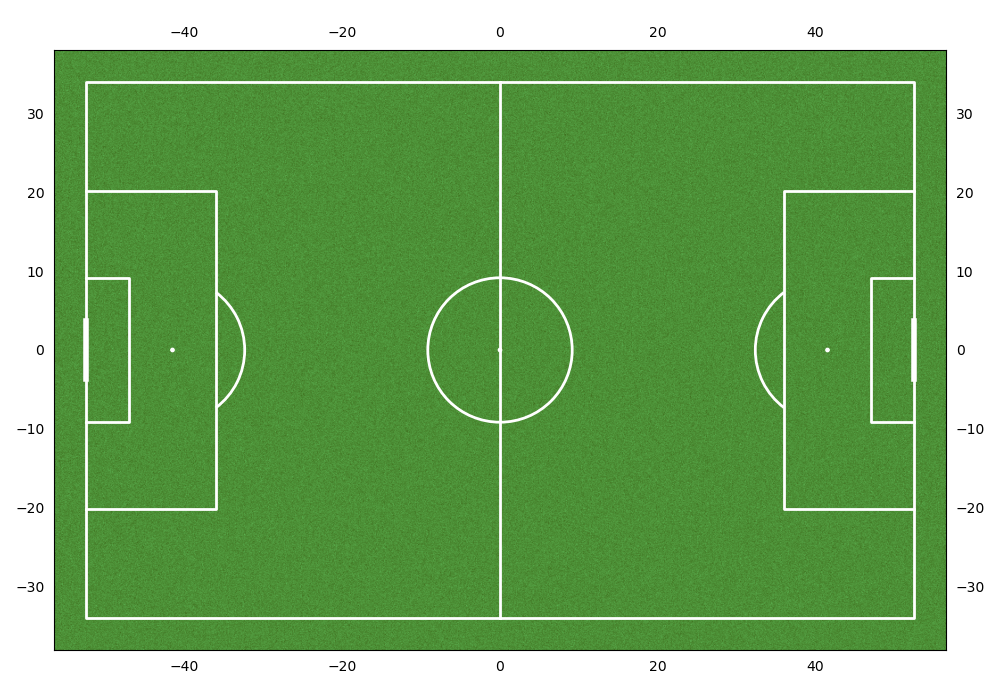

In [7]:
%matplotlib widget

import matplotlib.pyplot as plt
from mplsoccer import Pitch
import ipywidgets as widgets
from IPython.display import display

# Initialize plot
football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
fig, ax = football_pitch.draw(figsize=(10, 7))

# List to store points for the current situation and vectors
players =[]
points = []
vectors = []
situations = []

# Boolean to check if we're in vector drawing mode
draw_vector_mode = False
vector_start = None  # To store the start point of the vector

# Function to handle mouse clicks for points and vectors
def on_click(event):
    global vector_start, draw_vector_mode
    
    if event.inaxes:  # Check if click is inside plot
        x, y = event.xdata, event.ydata  # Get coordinates
        
        if draw_vector_mode:
            if vector_start is None:  # If no start point, set this as start point
                vector_start = (x, y)
                ax.plot(x, y, 'bo')  # Mark the start point with a blue dot
            else:
                # If there's already a start point, draw the vector from start to this point
                vector_end = (x, y)
                ax.annotate('', xy=vector_end, xytext=vector_start,
                            arrowprops=dict(facecolor='red', shrink=0.05))  # Draw vector
                vectors.append((vector_start, vector_end))  # Save the vector
                vector_start = None  # Reset the start point
        else:
            points.append((x, y))  # Add to list of points
            ax.plot(x, y, 'ro')  # Plot the point
        
        plt.draw()  # Redraw the figure

# Function to save the current situation
def save_situation(_):
    if points or vectors:
        situations.append({'points': list(points), 'vectors': list(vectors)})  # Save the current points and vectors
        print(f"Situation saved! Total saved situations: {len(situations)}")
    else:
        print("No players or vectors to save!")

# Function to clear the current situation
def clear_situation(_):
    global points, vectors, vector_start
    points = []  # Clear the current points
    vectors = []  # Clear the current vectors
    vector_start = None  # Reset vector start point
    ax.cla()  # Clear the plot
    football_pitch.draw(ax=ax)  # Redraw the empty pitch
    plt.draw()
    print("Cleared the current situation. You can now draw a new one.")

# Function to toggle vector drawing mode
def toggle_draw_vector(_):
    global draw_vector_mode
    draw_vector_mode = not draw_vector_mode  # Toggle the mode
    if draw_vector_mode:
        print("Vector drawing mode enabled. Select start and end points for the vector.")
    else:
        print("Switched to player drawing mode.")

def select_player(player_num):
    players.append(player_num)
    print(players)

def remove_player(player_num):
    try:
        players.remove(player_num)
        print(players)
    except:
        print("Player not in list")

# Create save, clear, and toggle vector buttons
save_button = widgets.Button(description="Save Situation", button_style='success')
clear_button = widgets.Button(description="Clear", button_style='warning')
toggle_vector_button = widgets.Button(description="Toggle Draw Vector", button_style='info')

#Create buttons for player filter
buttons = []
#Get unique players
players_xy = one_match.filter(regex="^home").columns.to_numpy()
player_numbers = np.array([player[:-1] for player in players_xy])
player_numbers = np.unique(player_numbers)


for number in player_numbers:
    save_button_player = widgets.Button(description=str(number))
    undo_button = widgets.Button(description="remove player "+str(number))
    save_button_player.on_click(lambda _, n=number: select_player(n))
    undo_button.on_click(lambda _, n=number: remove_player(n))
    buttons.append(save_button_player)
    buttons.append(undo_button)
    




# Connect button click events to their functions
save_button.on_click(save_situation)
clear_button.on_click(clear_situation)
toggle_vector_button.on_click(toggle_draw_vector)
buttons.append(save_button)
buttons.append(clear_button)
buttons.append(toggle_vector_button)
# Connect the click event to the handler
fig.canvas.mpl_connect('button_press_event', on_click)



# Display the buttons below the plot
display(widgets.HBox(buttons))

plt.show()



In [ ]:
regex = ""
for player in players:
    regex += "^"+player + "|" 
regex = regex[:-1]


#one_match = one_match.filter(regex = regex)
print(one_match.columns)

Index(['Time [s]', 'Time [s]_team', 'half_team', 'minute_team', 'Period_team',
       'home_6_x', 'home_6_y', 'home_18_x', 'home_18_y', 'home_1_x',
       'home_1_y', 'home_10_x', 'home_10_y', 'home_3_x', 'home_3_y',
       'home_2_x', 'home_2_y', 'home_19_x', 'home_19_y', 'home_21_x',
       'home_21_y', 'home_9_x', 'home_9_y', 'home_17_x', 'home_17_y',
       'home_23_x', 'home_23_y', 'home_20_x', 'home_20_y', 'home_15_x',
       'home_15_y', 'home_8_x', 'home_8_y', 'home_5_x', 'home_5_y',
       'home_12_x', 'home_12_y', 'ball_x_team', 'ball_y_team', 'ball_z_team',
       'half', 'minute', 'Period', 'away_10_x', 'away_10_y', 'away_2_x',
       'away_2_y', 'away_17_x', 'away_17_y', 'away_22_x', 'away_22_y',
       'away_9_x', 'away_9_y', 'away_1_x', 'away_1_y', 'away_20_x',
       'away_20_y', 'away_21_x', 'away_21_y', 'away_11_x', 'away_11_y',
       'away_13_x', 'away_13_y', 'away_6_x', 'away_6_y', 'away_7_x',
       'away_7_y', 'away_5_x', 'away_5_y', 'away_14_x', 'away_14_y',
   

In [ ]:
from libs.convex_hull import *

print(points)

hulls, indices = convex_hull(one_match.iloc[::48])

chosen_hull = ConvexHull(points)
chosen_hull = normalize_hull(chosen_hull)

top_100_hulls = top_n_similar_hulls(chosen_hull, hulls,indices,100)

relevant_situations = np.array(top_100_hulls)[:,1]

fig, ax = plt.subplots(2, 5, figsize=(15, 10))

# Create the pitch with the desired settings
for hull, i in zip(top_100_hulls[:10], range(len(top_100_hulls[:10]))):
    row = i // 5  # Determine the row index
    col = i % 5   # Determine the column index
    print(hull[1])
    # Create a new pitch on each subplot
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, 
                           label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax[row, col])  # Draw the pitch on the current axis
    
    # Scatter plot for convex hull points
    ax[row, col].scatter(hull[0].points[:, 0], hull[0].points[:, 1], color='red', s=10)

plt.tight_layout()
plt.show()
radii = np.arange(0, 34)

print(ripley_k(one_match.loc[85920].filter(regex ="^home"), radii, width=105.0, height=68.0))
points_array = np.array(points)
points_series = pd.Series(points_array.flatten())
print(ripley_k(points_series, radii, width=105.0, height=68.0))


[]


IndexError: tuple index out of range

In [ ]:
# Ensure the interactive pitch has captured points
if not points:
    print("Please click on the pitch to add points.")
else:
    print(f"Collected {len(points)} points.")

# Step 2: Convert the points from the interactive pitch into a usable format
points_array = np.array(points)  # Convert the collected points into a NumPy array

if points_array.shape[0] > 1:
    # Flatten the points for Ripley's K
    points_series = pd.Series(points_array.flatten())
    print(points_series)

    # Step 3: Define the radii for Ripley's K
    radii = np.arange(0, 34)  # Adjust the range based on your use case

    # Step 4: Calculate Ripley's K for the clicked points
    k_values_clicked = ripley_k(points_series, radii, width=105.0, height=68.0)

    # Step 5: Plot Ripley's K values for the clicked points
    plt.figure(figsize=(8, 6))
    plt.plot(radii, k_values_clicked, label="Ripley's K for Clicked Points")
    plt.xlabel('Distance (m)')
    plt.ylabel("K(d)")
    plt.title("Ripley's K Function for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

NameError: name 'points' is not defined

here
here


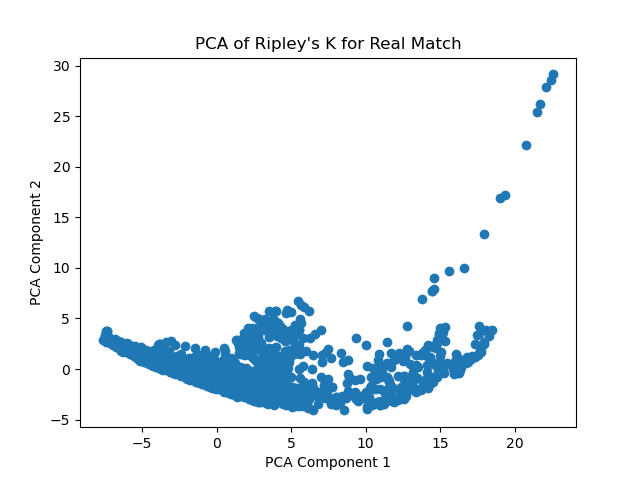

In [ ]:
# Step 7: Calculate Ripley's K values for the real match data

ripley_k_vals_relevant = ripley_k_by_indices(one_match, relevant_situations)


#Added average position of team as feature

# Step 8: Perform PCA on the Ripley's K values from the real match data
pca_obj_ripley = PCAObject(ripley_k_whole_match, 10)  # Fit PCA with 10 components
np_pca_ripley = pca_obj_ripley.transform(ripley_k_vals_relevant)
np_pca_ripley_full_match = pca_obj_ripley.transform(ripley_k_whole_match)

# Step 9: Plot the PCA-reduced Ripley's K values for the real match
plt.figure()
plt.scatter(np_pca_ripley_full_match[:, 0], np_pca_ripley_full_match[:, 1])
plt.title("PCA of Ripley's K for Real Match")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.savefig("pca_ripley.png")
plt.show()

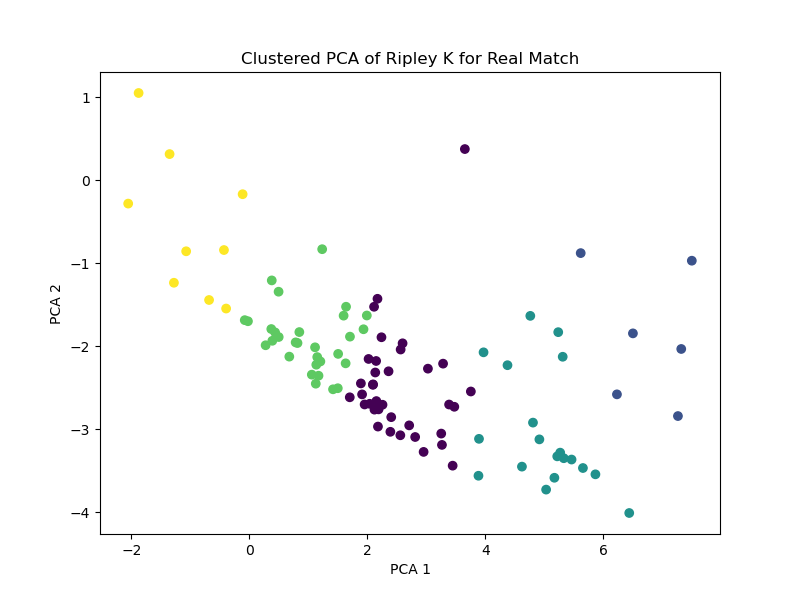

In [ ]:
# Step 10: Cluster the PCA-reduced Ripley's K values using KMeans
clustering_obj_ripley = KMeansObject(np_pca_ripley, 5)  # Fit KMeans with 5 clusters
labels = clustering_obj_ripley.get_labels()

# Step 11: Plot the clustered PCA-reduced Ripley's K values
plt.figure(figsize=(8, 6))
plt.scatter(np_pca_ripley[:, 0], np_pca_ripley[:, 1], c=labels, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Clustered PCA of Ripley K for Real Match')
plt.savefig("pca_ripley_clustered.png")
plt.show()

here


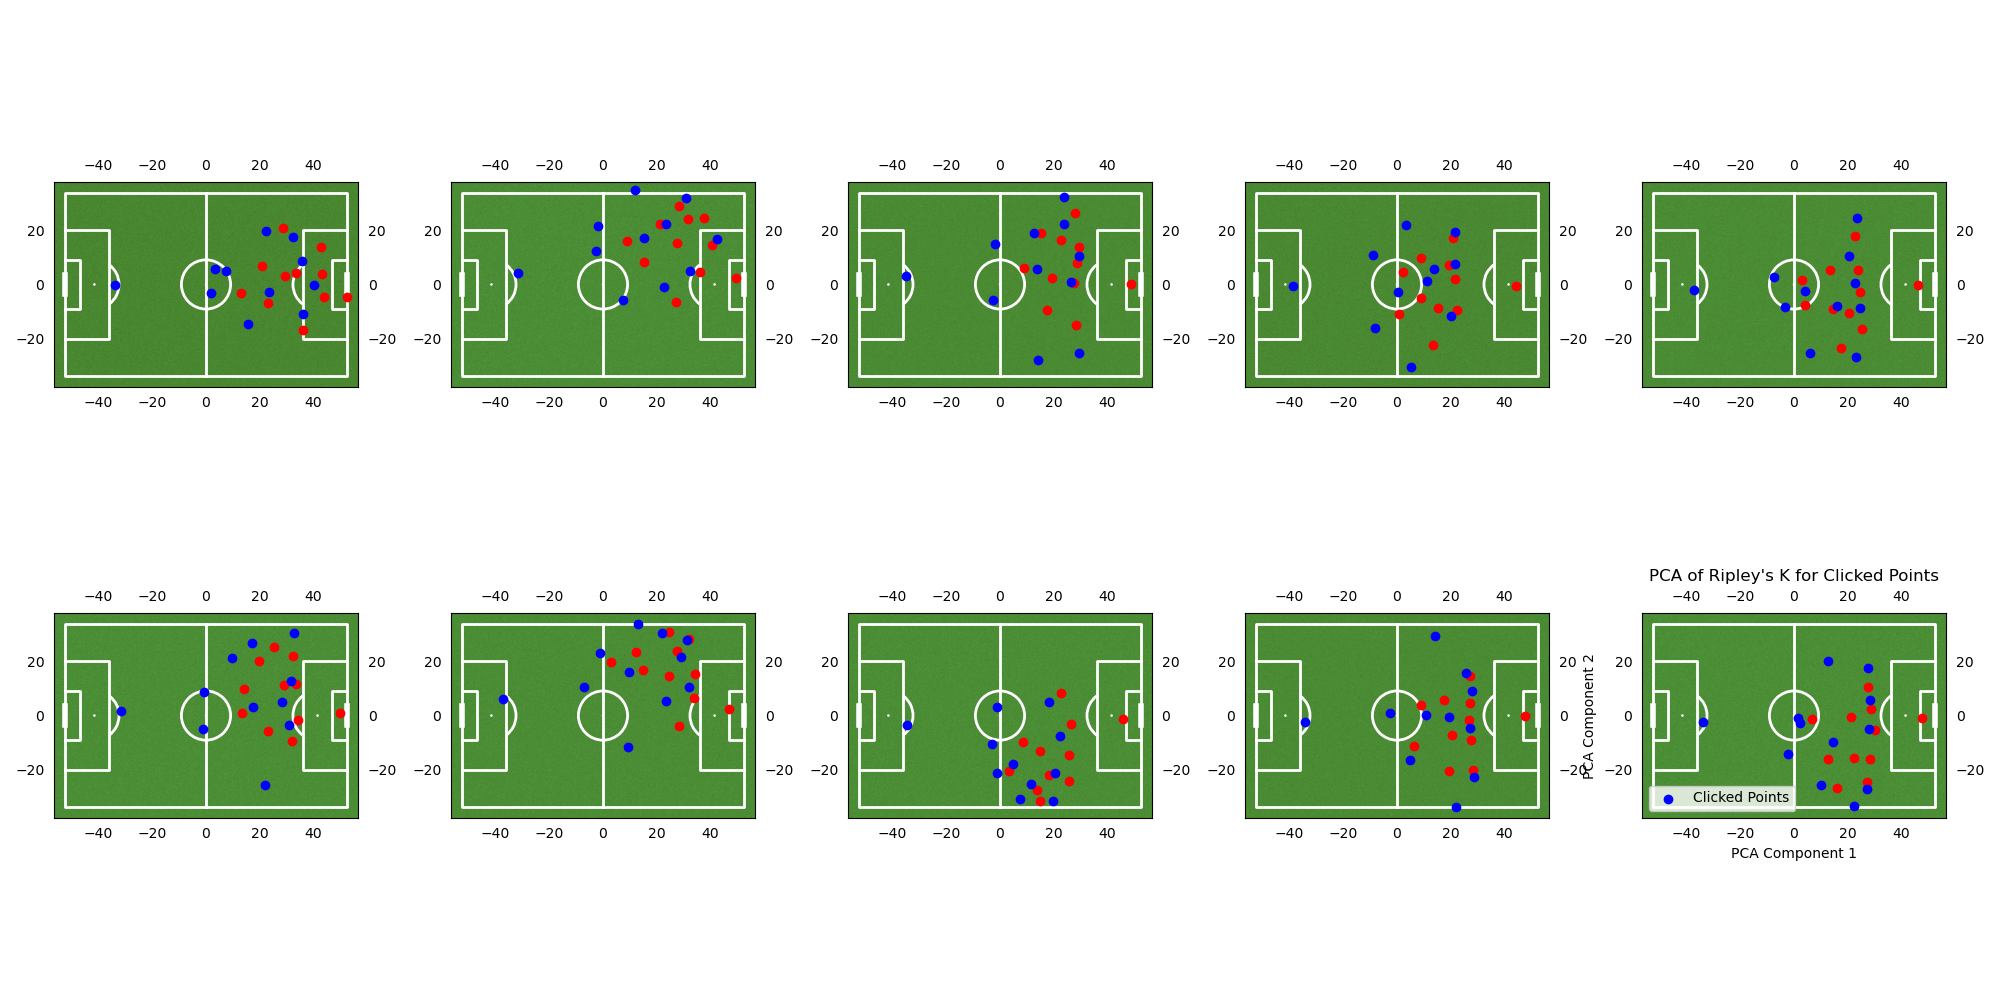

In [ ]:
# Step 12: Apply PCA on the Ripley's K values for the clicked points
if points_array.shape[0] > 1:
    
    k_values_clicked_new = np.array(k_values_clicked).reshape(1, -1)  # Reshape for PCA compatibility
   



    
  
    reduced_k_values_clicked = pca_obj_ripley.transform(k_values_clicked_new)  # Transform using the same PCA model

    # Step 13: Plot the PCA-reduced clicked points

    plt.scatter(reduced_k_values_clicked[:, 0], reduced_k_values_clicked[:, 1], c='blue', label='Clicked Points')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title("PCA of Ripley's K for Clicked Points")
    plt.legend()
    plt.show()
else:
    print("Not enough points for Ripley's K calculation.")

In [ ]:
from sklearn.neighbors import KDTree

# Step 1: Build a KDTree from the PCA-reduced real match data
tree = KDTree(np_pca_ripley)

# Step 2: Query the 10 nearest neighbors for the clicked situation
distances, indices = tree.query(reduced_k_values_clicked, k=10)  # Find 10 nearest neighbors

# Flatten the indices
closest_indices = indices.flatten()
print("Closest situation indices:", closest_indices)


Closest situation indices: [ 1  3 98 47 33 94 57 93 84 38]


In [ ]:
# Assuming `one_match` is a DataFrame where each row contains player positions for a specific situation
# Each row of `one_match` contains the player positions in the format: [(x1, y1), (x2, y2), ...]

# Retrieve the 10 closest situations from the real match

closest_situations_indices = np.array(top_100_hulls)[closest_indices,1]

print(closest_situations_indices)
closest_situations = one_match.loc[closest_situations_indices]


[119184 90624 47760 31536 35952 109104 111072 7872 47952 17520]


In [ ]:
one_match

Time [s]_team half_team  minute_team  Period_team   home_6_x  \
119184        4706.72        2H           78            2  43.044453   
90624         3564.32        2H           59            2  40.477463   
47760         1910.40        1H           31            1  28.823547   
31536         1261.44        1H           21            1  21.502663   
35952         1438.08        1H           23            1  24.617773   
109104        4303.52        2H           71            2  33.606945   
111072        4382.24        2H           73            2  34.033333   
7872           314.88        1H            5            1  25.650240   
47952         1918.08        1H           31            1  26.763676   
17520          700.80        1H           11            1  30.030350   

         home_6_y  home_18_x  home_18_y   home_1_x  home_1_y  ...  away_5_y  \
119184   3.994369  28.623697  21.123880  52.471657 -4.670624  ...  5.169617   
90624   14.502671  28.099606  29.208271  49.288734  2.395949  ...       NaN   
47760    8.017667  27.844173  26.450382  48.625191  0.257314  ...       NaN   
31536    1.860504  13.260823 -22.610281  44.128998 -0.531398  ...       NaN   
35952   -2.638156  22.686687  17.855516  46.083878 -0.042700  ...       NaN   
109104  11.799489  25.145205  25.375021  49.679623  1.073916  ...       NaN   
111072  15.379683  24.627409  31.144163  46.780609  2.308459  ...       NaN   
7872   -14.855664  22.734966   8.285743  45.634808 -1.300120  ...       NaN   
47952   -1.584595  27.216061  14.674927  47.504814 -0.331239  ...       NaN   
17520   -5.345769  27.664732  10.599998  47.610912 -0.882290  ...       NaN   

        away_14_x  away_14_y  away_23_x  away_23_y  away_19_x  away_19_y  \
119184        NaN        NaN        NaN        NaN   36.03183 -11.017366   
90624         NaN        NaN        NaN        NaN        NaN        NaN   
47760         NaN        NaN        NaN        NaN        NaN        NaN   
31536         NaN        NaN        NaN        NaN        NaN        NaN   
35952         NaN        NaN        NaN        NaN        NaN        NaN   
109104        NaN        NaN        NaN        NaN        NaN        NaN   
111072        NaN        NaN        NaN        NaN        NaN        NaN   
7872          NaN        NaN        NaN        NaN        NaN        NaN   
47952         NaN        NaN        NaN        NaN        NaN        NaN   
17520         NaN        NaN        NaN        NaN        NaN        NaN   

           ball_x     ball_y    ball_z  
119184        NaN        NaN       NaN  
90624         NaN        NaN       NaN  
47760   12.181014  18.947122  0.133708  
31536   -7.047939 -14.596207  0.149329  
35952    4.706216  -2.755569  3.057231  
109104  11.649433  23.332417  0.125087  
111072  23.717365  31.568771  2.595994  
7872    15.203862 -25.329743  0.096275  
47952    5.754971 -16.699241  0.136780  
17520   10.525628 -25.860835  0.096337  

[69126 rows x 56 columns]

In [ ]:
# Retrieve the 10 closest situations from the real match with time[s] column
closest_situations = one_match.loc[closest_indices,'Time [s]']  # Select time[s] along with other columns if needed


In [ ]:
# Add time step columns to the closest situations. Each index is 24 time ticks
closest_situations

1176    47.04
488     19.52
764     30.56
368     14.72
277     11.08
342     13.68
1275    51.00
756     30.24
1175    47.00
765     30.60
Name: Time [s], dtype: float64

AttributeError: 'numpy.float64' object has no attribute 'index'

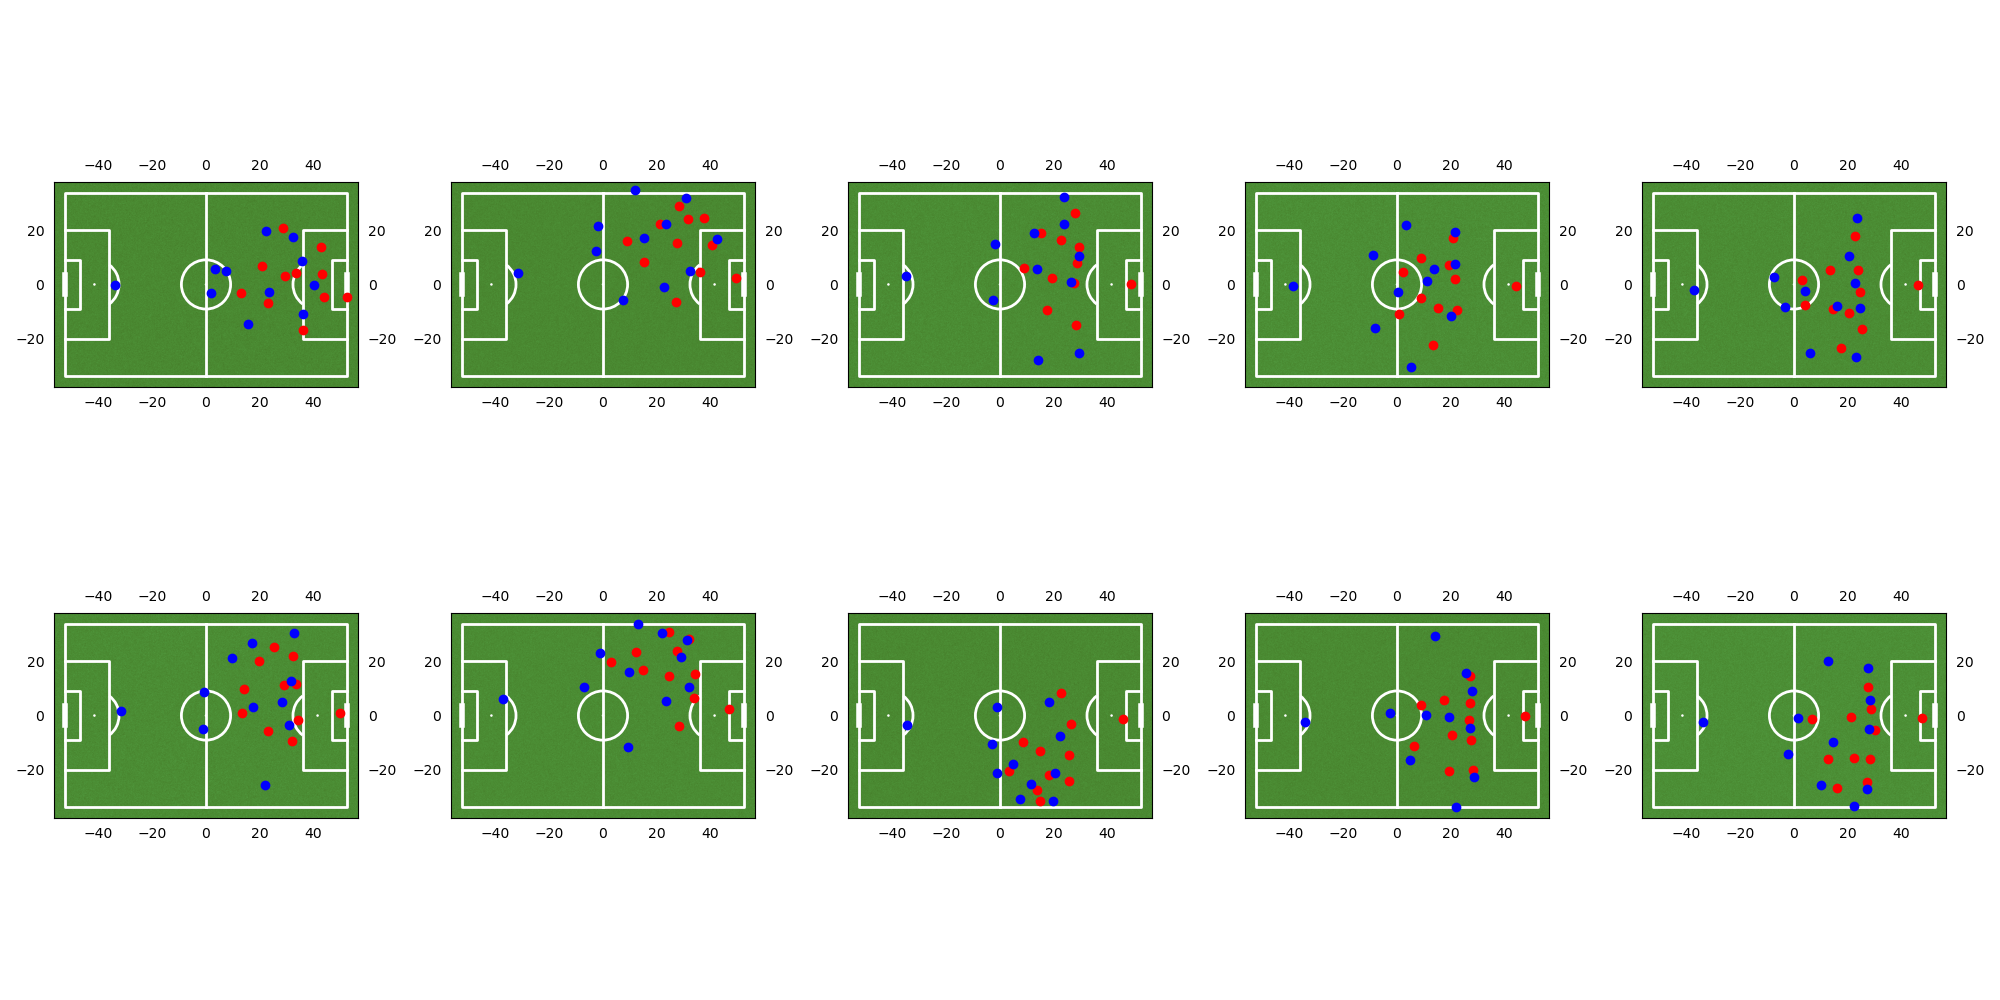

In [ ]:
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import pandas as pd

# Function to extract player coordinates from the DataFrame
def extract_player_positions(row):
    # Extract home player positions (x and y)
    home_x_cols = [col for col in row.index if 'home' in col and '_x' in col]
    home_y_cols = [col for col in row.index if 'home' in col and '_y' in col]
    
    home_positions = [(row[x], row[y]) for x, y in zip(home_x_cols, home_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    # Extract away player positions (x and y)
    away_x_cols = [col for col in row.index if 'away' in col and '_x' in col]
    away_y_cols = [col for col in row.index if 'away' in col and '_y' in col]
    
    away_positions = [(row[x], row[y]) for x, y in zip(away_x_cols, away_y_cols) if not pd.isna(row[x]) and not pd.isna(row[y])]

    return home_positions, away_positions

# Function to plot a single situation on the pitch
def plot_situation(row, ax):
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax)
    
    # Extract player positions from the row
    home_positions, away_positions = extract_player_positions(row)
    
    # Plot home team players (red)
    for pos in home_positions:
        ax.plot(pos[0], pos[1], 'ro', label='Home Team')  # Mark home players as red dots

    # Plot away team players (blue)
    for pos in away_positions:
        ax.plot(pos[0], pos[1], 'bo', label='Away Team')  # Mark away players as blue dots
    
    ax.set_title(f"Situation at Time: {row['Time [s]']:.2f} sec")

# Step 4: Visualize the 10 closest situations on the pitch
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # Create a grid for 10 situations
axes = axes.flatten()

# Make sure closest_situations contains all required columns from the original DataFrame
if 'Time [s]' in closest_situations.columns:
    for idx, situation_index in enumerate(closest_situations.index):  # Use the index of the closest situations
        plot_situation(closest_situations.loc[situation_index], axes[idx])  # Pass the row to plot_situation
else:
    print("Ensure that closest_situations contains full rows, including player position columns.")

plt.tight_layout()
plt.show()
